In [3]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

from qiskit.visualization import plot_histogram

In [4]:
# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = qi.Operator([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = qi.Operator([[1, 0, 0, 0],
                        [0, 0, 1j, 0],
                        [0, 1j, 0, 0],
                        [0, 0, 0, 1]])

In [5]:
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = QuantumCircuit(2, name='cx<iSWAP>')

# Add gates
cx_circ.sdg(1)
cx_circ.h(1)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.sdg(0)
cx_circ.h(0)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.s(1)

print(cx_circ)

     ┌─────┐     ┌────────┐┌─────┐┌───┐┌─────┐┌────────┐     
q_0: ┤ Sdg ├─────┤0       ├┤ Sdg ├┤ H ├┤ Sdg ├┤0       ├─────
     ├─────┤┌───┐│  iswap │└─────┘└───┘└─────┘│  iswap │┌───┐
q_1: ┤ Sdg ├┤ H ├┤1       ├───────────────────┤1       ├┤ S ├
     └─────┘└───┘└────────┘                   └────────┘└───┘


In [6]:
# Simulate the unitary for the circuit using Operator:
unitary = qi.Operator(cx_circ)
print(unitary)

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [7]:
'unitary' in AerSimulator().configuration().basis_gates

True

In [8]:
# Error parameters
param_q0 = 0.05  # damping parameter for qubit-0
param_q1 = 0.1   # damping parameter for qubit-1

# Construct the error
qerror_q0 = amplitude_damping_error(param_q0)
qerror_q1 = amplitude_damping_error(param_q1)
iswap_error = qerror_q1.tensor(qerror_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')

In [10]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(2, 2, name='bell')
bell_circ.h(0)
bell_circ.append(cx_circ, [0, 1])
bell_circ.measure([0,1], [0,1])
print(bell_circ)

     ┌───┐┌────────────┐┌─┐   
q_0: ┤ H ├┤0           ├┤M├───
     └───┘│  cx<iSWAP> │└╥┘┌─┐
q_1: ─────┤1           ├─╫─┤M├
          └────────────┘ ║ └╥┘
c: 2/════════════════════╩══╩═
                         0  1 


['cx', 'id', 'rz', 'sx', 'unitary']


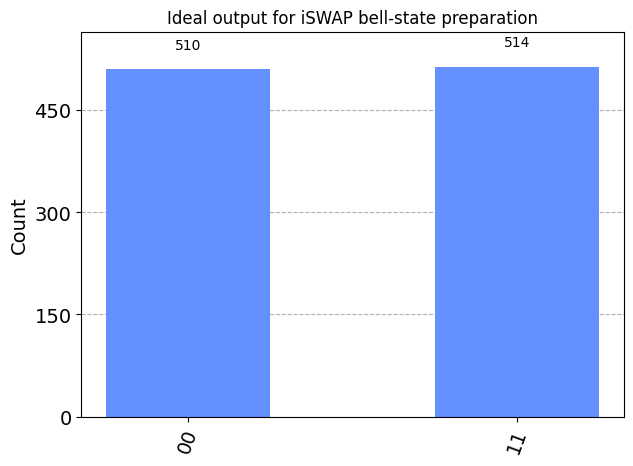

In [11]:
noise_model.add_basis_gates(['unitary'])
print(noise_model.basis_gates)
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
tbell_circ = transpile(bell_circ, sim_ideal)

ideal_result = sim_ideal.run(tbell_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for iSWAP bell-state preparation')

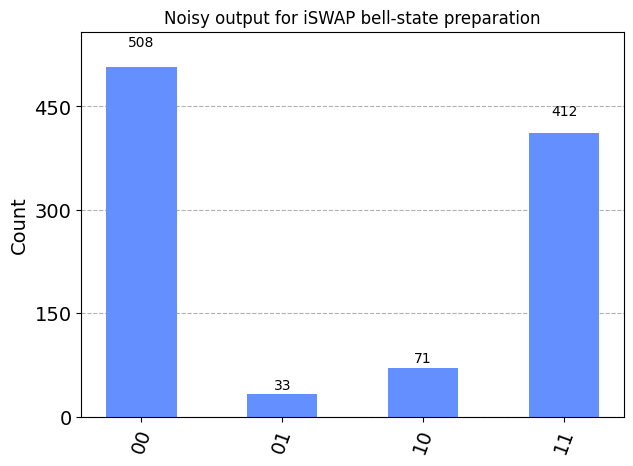

In [12]:
# Create noisy simulator and transpile circuit
sim_noise = AerSimulator(noise_model=noise_model)
tbell_circ_noise = transpile(bell_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(tbell_circ_noise).result()
noise_counts = noise_result.get_counts(bell_circ)
plot_histogram(noise_counts,
               title='Noisy output for iSWAP bell-state preparation')